# Feature Space Exploration

Analyze and visualize the feature representations learned by similarity methods.

**What this notebook covers:**
- Feature statistics and distributions
- Dimensionality reduction (PCA, t-SNE)
- Cluster analysis
- Intra/inter-class separability
- Nearest neighbor exploration

**Prerequisites:**
- Run an experiment to generate feature caches in `artifacts/feature_cache/`
- Ensure features are cached (don't use `--no-cache` flag)

## 1. Setup & Configuration

In [51]:
import sys
print("Python executable:", sys.executable)
print("Should show: D:\\sim-bench\\.venv\\Scripts\\python.exe")

Python executable: d:\sim-bench\.venv\Scripts\python.exe
Should show: D:\sim-bench\.venv\Scripts\python.exe


In [52]:
! pip show sim_bench

Name: sim-bench
Version: 0.1.0
Summary: Simple, config-driven image similarity benchmarking (UKBench baseline)
Home-page: 
Author: Your Name
Author-email: 
License: MIT
Location: D:\sim-bench\.venv\Lib\site-packages
Editable project location: D:\sim-bench
Requires: matplotlib, numpy, opencv-contrib-python, pandas, Pillow, PyYAML, scikit-learn, scipy, tqdm
Required-by: 


In [53]:
from sim_bench import cli

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Import analysis utilities
from sim_bench.analysis import utils, feature_utils, feature_viz

# Import ML libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

print("✓ Imports successful")

✓ Imports successful


In [55]:
# ========================================
# CONFIGURATION - MODIFY THESE
# ========================================

# Get project root (works regardless of where notebook is run from)
PROJECT_ROOT = utils.get_project_root()

# Method to analyze
METHOD_NAME = "deep"  # Options: 'deep', 'chi_square', 'emd', 'sift_bovw'

# Dataset info (for extracting ground-truth labels from paths)
DATASET_TYPE = "ukbench"  # Options: 'ukbench', 'holidays'

# Paths (relative to project root)
FEATURE_CACHE_DIR = PROJECT_ROOT / "artifacts" / "feature_cache"
OUTPUT_DIR = PROJECT_ROOT / "outputs" / "feature_exploration"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Analysis parameters
N_PCA_COMPONENTS = 50  # Number of PCA components to compute
N_TSNE_SAMPLES = 500   # Number of samples for t-SNE (faster with fewer samples)
N_CLUSTERS = 10        # Number of clusters for K-means
RANDOM_SEED = 42

print(f"Configuration:")
print(f"  Project Root: {PROJECT_ROOT}")
print(f"  Method: {METHOD_NAME}")
print(f"  Dataset: {DATASET_TYPE}")
print(f"  Feature Cache: {FEATURE_CACHE_DIR}")
print(f"  Output: {OUTPUT_DIR}")

Configuration:
  Project Root: D:\sim-bench
  Method: deep
  Dataset: ukbench
  Feature Cache: D:\sim-bench\artifacts\feature_cache
  Output: D:\sim-bench\outputs\feature_exploration


## 2. Load Features from Cache

In [56]:
FEATURE_CACHE_DIR

WindowsPath('D:/sim-bench/artifacts/feature_cache')

In [57]:
# List all available caches
cache_list = feature_utils.list_feature_caches(FEATURE_CACHE_DIR)
print("Available feature caches:")
print(cache_list.to_string(index=False))
print(f"\nTotal: {len(cache_list)} cache files")

# Find cache for specified method
cache_file = feature_utils.find_cache_for_method(METHOD_NAME, FEATURE_CACHE_DIR)

if cache_file is None:
    raise FileNotFoundError(
        f"No cache found for method '{METHOD_NAME}'. "
        f"Run an experiment first with: python -m sim_bench.cli --methods {METHOD_NAME}"
    )

print(f"\nUsing cache: {cache_file.name}")

# Load features and metadata
features, metadata = feature_utils.load_features_from_cache(cache_file, return_metadata=True)

print(f"\n✓ Loaded features from cache")
print(f"\nMetadata:")
print(f"  Method: {metadata['method_name']}")
print(f"  Number of images: {metadata['n_images']}")
print(f"  Feature dimension: {metadata['feature_dim']}")
print(f"  Feature matrix shape: {features.shape}")
print(f"  Memory size: {features.nbytes / (1024**2):.2f} MB")

# Store for later use
image_paths = metadata['image_paths']
n_images = len(image_paths)
feature_dim = features.shape[1]

Available feature caches:
                       filename method    size_mb                                                                 path
chi_square_22dffecf6489e589.pkl    chi 159.949400 D:\sim-bench\artifacts\feature_cache\chi_square_22dffecf6489e589.pkl
chi_square_2d44832281f75a48.pkl    chi  23.379740 D:\sim-bench\artifacts\feature_cache\chi_square_2d44832281f75a48.pkl
chi_square_505b1e08254b38d5.pkl    chi   1.254883 D:\sim-bench\artifacts\feature_cache\chi_square_505b1e08254b38d5.pkl
chi_square_5a37b4bd339026e7.pkl    chi   4.296788 D:\sim-bench\artifacts\feature_cache\chi_square_5a37b4bd339026e7.pkl
chi_square_e3f15933152f0aca.pkl    chi   6.272889 D:\sim-bench\artifacts\feature_cache\chi_square_e3f15933152f0aca.pkl
      deep_6d1e6b231e77eb73.pkl   deep   0.629846       D:\sim-bench\artifacts\feature_cache\deep_6d1e6b231e77eb73.pkl
      deep_ab24f5f0c42f5863.pkl   deep   2.156126       D:\sim-bench\artifacts\feature_cache\deep_ab24f5f0c42f5863.pkl
      deep_da0d71c2fe4

In [58]:
# Extract ground-truth labels from image paths
try:
    labels = feature_utils.extract_group_labels_from_paths(image_paths, DATASET_TYPE)
    n_unique_groups = len(np.unique(labels[labels >= 0]))
    print(f"✓ Extracted ground-truth labels")
    print(f"  Number of unique groups: {n_unique_groups}")
    print(f"  Label range: {labels.min()} to {labels.max()}")
except Exception as e:
    print(f"⚠ Could not extract labels: {e}")
    labels = None

✓ Extracted ground-truth labels
  Number of unique groups: 2550
  Label range: 0 to 2549


## 3. Feature Statistics & Distribution Analysis

Feature Statistics Summary:
              mean          std     min          max       median
count  2048.000000  2048.000000  2048.0  2048.000000  2048.000000
mean      0.006470     0.016813     0.0     0.313458     0.000793
std       0.006497     0.011029     0.0     0.154876     0.003072
min       0.000440     0.002110     0.0     0.041838     0.000000
25%       0.002371     0.008454     0.0     0.192334     0.000000
50%       0.004583     0.014595     0.0     0.289234     0.000000
75%       0.008474     0.022393     0.0     0.406447     0.000630
max       0.099773     0.103298     0.0     0.951673     0.095213

Top 10 dimensions by variance:
 dimension     mean      std    range
       371 0.056476 0.103298 0.746664
       206 0.047555 0.084470 0.622756
      1994 0.038881 0.077749 0.626625
      1098 0.052720 0.072995 0.587388
       370 0.039550 0.071432 0.560043
      1020 0.032287 0.069806 0.703882
       680 0.036731 0.067203 0.559142
       835 0.047961 0.065617 0.582467
    

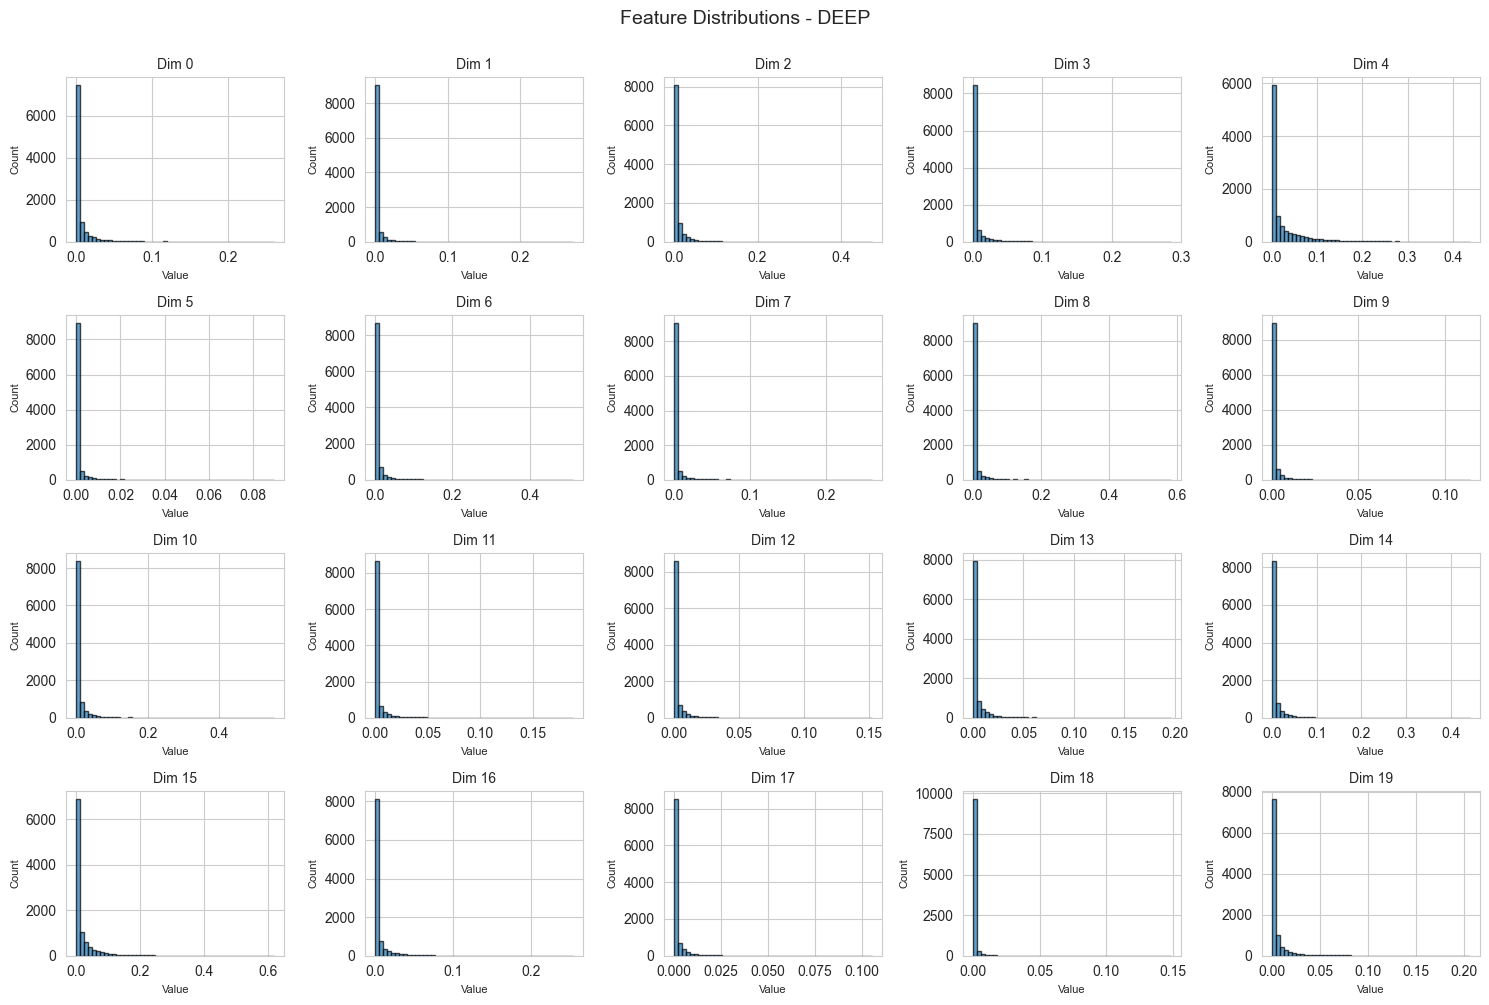

In [59]:
# Compute comprehensive statistics
stats_df = feature_utils.compute_feature_statistics(features)

print("Feature Statistics Summary:")
print(stats_df[['mean', 'std', 'min', 'max', 'median']].describe())

print("\nTop 10 dimensions by variance:")
top_var_dims = stats_df.nlargest(10, 'std')[['dimension', 'mean', 'std', 'range']]
print(top_var_dims.to_string(index=False))

# Plot feature distributions
fig = feature_viz.plot_feature_distributions(
    features, max_dims=20,
    title=f"Feature Distributions - {METHOD_NAME.upper()}"
)
plt.savefig(OUTPUT_DIR / f"{METHOD_NAME}_feature_distributions.png", bbox_inches='tight', dpi=150)
plt.show()

## 4. Query Specific Images

Extract and analyze features for specific images.

In [60]:
# Get query indices from per_query.csv (consistent with other analyses)
# You'll need to set METHOD_NAME and have an experiment directory

# Option 1: Load from per_query.csv to see available queries
# Uncomment and configure if you have an experiment directory:
# from sim_bench.analysis import io
# from sim_bench.analysis.config import set_global_config, GlobalAnalysisConfig
# EXPERIMENT_DIR = PROJECT_ROOT / "outputs" / "your_experiment_timestamp"
# set_global_config(GlobalAnalysisConfig(experiment_dir=EXPERIMENT_DIR).resolve())
# per_query_df = io.load_per_query(METHOD_NAME)
# print(per_query_df[['query_idx', 'query_path']].head(20))

# Option 2: Directly specify query indices
# These are the indices in the dataset (0-based)
query_indices = list(range(7144, 7152))  # Modify these to your desired query indices

print(f"Selected {len(query_indices)} queries: {query_indices}")

Selected 8 queries: [7144, 7145, 7146, 7147, 7148, 7149, 7150, 7151]


In [61]:
# Extract features for the specified query indices
try:
    query_features = feature_utils.get_features_by_index(query_indices, cache_file)
    
    print(f"✓ Extracted features for {len(query_indices)} queries")
    print(f"  Features shape: {query_features.shape}")
    
    # Get image paths for these queries
    query_paths = [feature_utils.get_image_path_by_index(idx, cache_file) for idx in query_indices]
    
    print(f"\nQuery images:")
    for idx, path in zip(query_indices, query_paths):
        print(f"  [{idx:4d}] {Path(path).name}")
    
    # Display feature statistics for queried images
    print(f"\nFeature statistics:")
    print(f"  Mean: {query_features.mean():.4f}")
    print(f"  Std:  {query_features.std():.4f}")
    print(f"  Min:  {query_features.min():.4f}")
    print(f"  Max:  {query_features.max():.4f}")
    
except IndexError as e:
    print(f"Error: {e}")
    print(f"\nTip: Valid indices are 0 to {len(image_paths)-1}")

✓ Extracted features for 8 queries
  Features shape: (8, 2048)

Query images:
  [7144] ukbench07144.jpg
  [7145] ukbench07145.jpg
  [7146] ukbench07146.jpg
  [7147] ukbench07147.jpg
  [7148] ukbench07148.jpg
  [7149] ukbench07149.jpg
  [7150] ukbench07150.jpg
  [7151] ukbench07151.jpg

Feature statistics:
  Mean: 0.0052
  Std:  0.0215
  Min:  0.0000
  Max:  0.4337


In [62]:
# Extract group IDs for all images and query images
all_group_ids = feature_utils.extract_group_labels_from_paths(image_paths, DATASET_TYPE)
query_group_ids = [all_group_ids[idx] for idx in query_indices]

print(f"Query group IDs: {query_group_ids}")
print(f"Unique groups in queries: {set(query_group_ids)}")

Query group IDs: [1786, 1786, 1786, 1786, 1787, 1787, 1787, 1787]
Unique groups in queries: {1786, 1787}


In [63]:
# Compute pairwise distances between query images
from scipy.spatial.distance import cdist

if len(query_features) > 1:
    # Compute pairwise distances
    distances = cdist(query_features, query_features, metric='euclidean')
    
    print(f"Pairwise distances between {len(query_indices)} queries:")
    print(f"\nDistance matrix:")
    
    # Create a formatted table with group info
    import pandas as pd
    dist_df = pd.DataFrame(
        distances,
        index=[f"q{idx}(g{gid})" for idx, gid in zip(query_indices, query_group_ids)],
        columns=[f"q{idx}(g{gid})" for idx, gid in zip(query_indices, query_group_ids)]
    )
    print(dist_df.to_string())
    
    # Find most similar pair
    np.fill_diagonal(distances, np.inf)  # Ignore self-distances
    min_idx = np.unravel_index(distances.argmin(), distances.shape)
    print(f"\nMost similar pair:")
    print(f"  query_{query_indices[min_idx[0]]} (group {query_group_ids[min_idx[0]]}) <-> "
          f"query_{query_indices[min_idx[1]]} (group {query_group_ids[min_idx[1]]})")
    print(f"  Distance: {distances[min_idx]:.4f}")
    
    # Find most dissimilar pair
    max_idx = np.unravel_index(distances[distances != np.inf].argmax(), distances.shape)
    print(f"\nMost dissimilar pair:")
    print(f"  query_{query_indices[max_idx[0]]} (group {query_group_ids[max_idx[0]]}) <-> "
          f"query_{query_indices[max_idx[1]]} (group {query_group_ids[max_idx[1]]})")
    print(f"  Distance: {distances[max_idx]:.4f}")
else:
    print("Need at least 2 queries to compute pairwise distances")

Pairwise distances between 8 queries:

Distance matrix:
              q7144(g1786)  q7145(g1786)  q7146(g1786)  q7147(g1786)  q7148(g1787)  q7149(g1787)  q7150(g1787)  q7151(g1787)
q7144(g1786)      0.000000      0.823152      0.543967      0.423398      0.545822      0.777291      0.660873      0.711585
q7145(g1786)      0.823152      0.000000      0.768183      0.861435      0.955243      0.927689      0.839519      0.763976
q7146(g1786)      0.543967      0.768183      0.000000      0.699148      0.677611      0.764765      0.718271      0.788500
q7147(g1786)      0.423398      0.861435      0.699148      0.000000      0.581692      0.846386      0.755928      0.732665
q7148(g1787)      0.545822      0.955243      0.677611      0.581692      0.000000      0.746316      0.593281      0.684566
q7149(g1787)      0.777291      0.927689      0.764765      0.846386      0.746316      0.000000      0.678342      0.763345
q7150(g1787)      0.660873      0.839519      0.718271      0.755928 

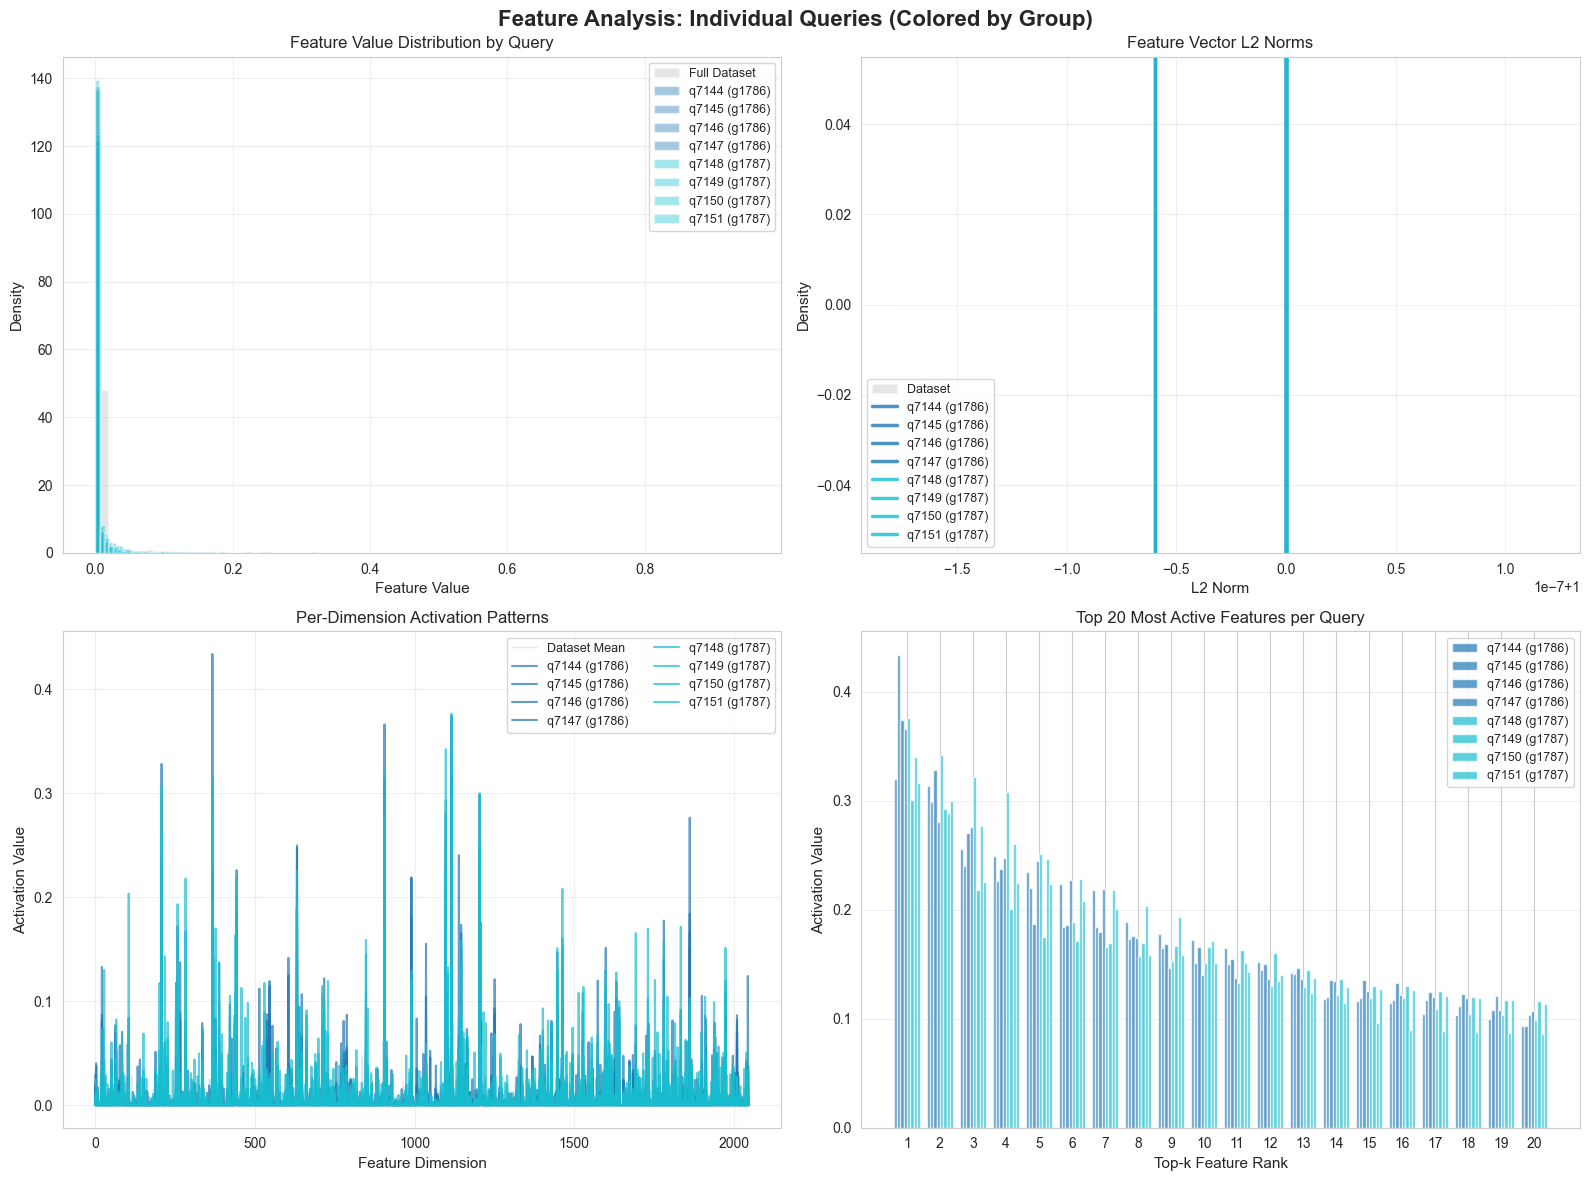


Visualization saved to: D:\sim-bench\outputs\feature_exploration\query_feature_analysis_by_group.png

Query Summary:
  Query 7144 (Group 1786): L2 norm = 1.0000
  Query 7145 (Group 1786): L2 norm = 1.0000
  Query 7146 (Group 1786): L2 norm = 1.0000
  Query 7147 (Group 1786): L2 norm = 1.0000
  Query 7148 (Group 1787): L2 norm = 1.0000
  Query 7149 (Group 1787): L2 norm = 1.0000
  Query 7150 (Group 1787): L2 norm = 1.0000
  Query 7151 (Group 1787): L2 norm = 1.0000


In [64]:
# Visualize feature statistics for each query image (colored by group)
import matplotlib.pyplot as plt
import matplotlib.cm as cm

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle(f'Feature Analysis: Individual Queries (Colored by Group)', 
             fontsize=16, fontweight='bold')

# Get colors for groups
unique_groups = sorted(set(query_group_ids))
colors = cm.tab10(np.linspace(0, 1, len(unique_groups)))
group_to_color = dict(zip(unique_groups, colors))

# 1. Feature value distributions by query
ax = axes[0, 0]
# Show dataset in background
ax.hist(features.flatten(), bins=50, alpha=0.2, label='Full Dataset', 
        density=True, color='gray')
# Show each query
for i, (qidx, gid) in enumerate(zip(query_indices, query_group_ids)):
    ax.hist(query_features[i], bins=50, alpha=0.4, 
            label=f'q{qidx} (g{gid})', density=True, 
            color=group_to_color[gid])
ax.set_xlabel('Feature Value', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Feature Value Distribution by Query', fontsize=12)
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# 2. L2 norms by query
ax = axes[0, 1]
dataset_norms = np.linalg.norm(features, axis=1)
query_norms = np.linalg.norm(query_features, axis=1)
# Background histogram
ax.hist(dataset_norms, bins=50, alpha=0.2, label='Dataset', 
        density=True, color='gray')
# Plot each query's norm as a vertical line
for i, (qidx, gid, qnorm) in enumerate(zip(query_indices, query_group_ids, query_norms)):
    ax.axvline(qnorm, color=group_to_color[gid], linewidth=2.5, 
               alpha=0.8, label=f'q{qidx} (g{gid})')
ax.set_xlabel('L2 Norm', fontsize=11)
ax.set_ylabel('Density', fontsize=11)
ax.set_title('Feature Vector L2 Norms', fontsize=12)
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3)

# 3. Per-dimension activations (show each query as a line)
ax = axes[1, 0]
dims = np.arange(query_features.shape[1])
dataset_mean = features.mean(axis=0)
# Show dataset mean in background
ax.plot(dims, dataset_mean, color='lightgray', linewidth=1, 
        alpha=0.5, label='Dataset Mean')
# Show each query
for i, (qidx, gid) in enumerate(zip(query_indices, query_group_ids)):
    ax.plot(dims, query_features[i], color=group_to_color[gid], 
            linewidth=1.5, alpha=0.7, label=f'q{qidx} (g{gid})')
ax.set_xlabel('Feature Dimension', fontsize=11)
ax.set_ylabel('Activation Value', fontsize=11)
ax.set_title('Per-Dimension Activation Patterns', fontsize=12)
ax.legend(fontsize=9, loc='best', ncol=2)
ax.grid(True, alpha=0.3)

# 4. Top-k most active dimensions per query
ax = axes[1, 1]
top_k = 20
width = 0.8 / len(query_indices)
x_base = np.arange(top_k)

for i, (qidx, gid) in enumerate(zip(query_indices, query_group_ids)):
    # Get top-k features for this query
    top_dims = np.argsort(np.abs(query_features[i]))[-top_k:][::-1]
    top_vals = query_features[i][top_dims]
    
    # Plot as bars
    x_pos = x_base + i * width
    ax.bar(x_pos, top_vals, width=width, 
           color=group_to_color[gid], alpha=0.7, 
           label=f'q{qidx} (g{gid})')

ax.set_xlabel('Top-k Feature Rank', fontsize=11)
ax.set_ylabel('Activation Value', fontsize=11)
ax.set_title(f'Top {top_k} Most Active Features per Query', fontsize=12)
ax.set_xticks(x_base + width * (len(query_indices) - 1) / 2)
ax.set_xticklabels([f'{i+1}' for i in range(top_k)])
ax.legend(fontsize=9, loc='best')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
output_file = OUTPUT_DIR / f'query_feature_analysis_by_group.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {output_file}")
print(f"\nQuery Summary:")
for qidx, gid, qnorm in zip(query_indices, query_group_ids, query_norms):
    print(f"  Query {qidx} (Group {gid}): L2 norm = {qnorm:.4f}")

In [31]:
# Find nearest neighbors in the full dataset for each query
from scipy.spatial.distance import cdist

# Compute distances from queries to all images in dataset
all_distances = cdist(query_features, features, metric='euclidean')

# For each query, find top-k nearest neighbors
top_k = 10

for i, query_idx in enumerate(query_indices):
    print(f"\n{'='*80}")
    print(f"Query {query_idx} (group {query_group_ids[i]}): {Path(query_paths[i]).name}")
    print(f"{'='*80}")
    
    # Get distances for this query
    dists = all_distances[i]
    
    # Find nearest neighbors
    nearest_indices = np.argsort(dists)[:top_k]
    
    print(f"\nTop {top_k} nearest neighbors:")
    for rank, idx in enumerate(nearest_indices, 1):
        neighbor_path = image_paths[idx]
        neighbor_group = all_group_ids[idx]
        distance = dists[idx]
        is_self = "(SELF)" if idx == query_idx else ""
        same_group = "✓" if neighbor_group == query_group_ids[i] else " "
        print(f"  {same_group} {rank:2d}. idx={idx:4d} group={neighbor_group:3d}  "
              f"{Path(neighbor_path).name:30s}  dist={distance:.4f} {is_self}")


Query 7144 (group 1786): ukbench07144.jpg

Top 10 nearest neighbors:
  ✓  1. idx=7144 group=1786  ukbench07144.jpg                dist=0.0000 (SELF)
  ✓  2. idx=7147 group=1786  ukbench07147.jpg                dist=0.4234 
  ✓  3. idx=7146 group=1786  ukbench07146.jpg                dist=0.5440 
     4. idx=7148 group=1787  ukbench07148.jpg                dist=0.5458 
     5. idx=7150 group=1787  ukbench07150.jpg                dist=0.6609 
     6. idx=7151 group=1787  ukbench07151.jpg                dist=0.7116 
     7. idx=7149 group=1787  ukbench07149.jpg                dist=0.7773 
  ✓  8. idx=7145 group=1786  ukbench07145.jpg                dist=0.8232 
     9. idx=3306 group=826  ukbench03306.jpg                dist=0.9243 
    10. idx=7096 group=1774  ukbench07096.jpg                dist=0.9253 

Query 7145 (group 1786): ukbench07145.jpg

Top 10 nearest neighbors:
  ✓  1. idx=7145 group=1786  ukbench07145.jpg                dist=0.0000 (SELF)
     2. idx=7151 group=1787  ukbenc

### Visualize Query Images Only (Colored by Group)

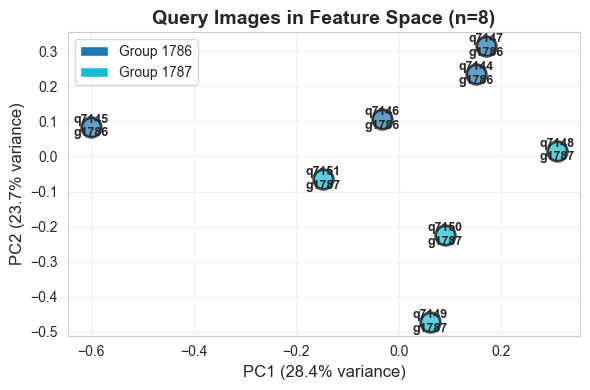


Visualization saved to: D:\sim-bench\outputs\feature_exploration\query_images_by_group.png


In [32]:
# Visualize query images in feature space (colored by group)
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

if len(query_features) > 2:
    # Reduce to 2D using PCA
    pca = PCA(n_components=2)
    query_2d = pca.fit_transform(query_features)
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    
    # Get unique groups and assign colors
    unique_groups = sorted(set(query_group_ids))
    colors = cm.tab10(np.linspace(0, 1, len(unique_groups)))
    group_to_color = dict(zip(unique_groups, colors))
    
    # Plot each query
    for i, (idx, gid) in enumerate(zip(query_indices, query_group_ids)):
        ax.scatter(query_2d[i, 0], query_2d[i, 1], 
                  c=[group_to_color[gid]], s=200, alpha=0.7, 
                  edgecolors='black', linewidth=2)
        ax.annotate(f'q{idx}\ng{gid}', 
                   (query_2d[i, 0], query_2d[i, 1]),
                   fontsize=9, ha='center', va='center', fontweight='bold')
    
    # Legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=group_to_color[g], label=f'Group {g}') 
                      for g in unique_groups]
    ax.legend(handles=legend_elements, loc='best', fontsize=10)
    
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
    ax.set_title(f'Query Images in Feature Space (n={len(query_indices)})', 
                fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    output_file = OUTPUT_DIR / 'query_images_by_group.png'
    plt.savefig(output_file, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nVisualization saved to: {output_file}")
else:
    print("Need at least 3 queries for meaningful 2D visualization")

### Visualize Queries vs Full Dataset (Colored by Group)

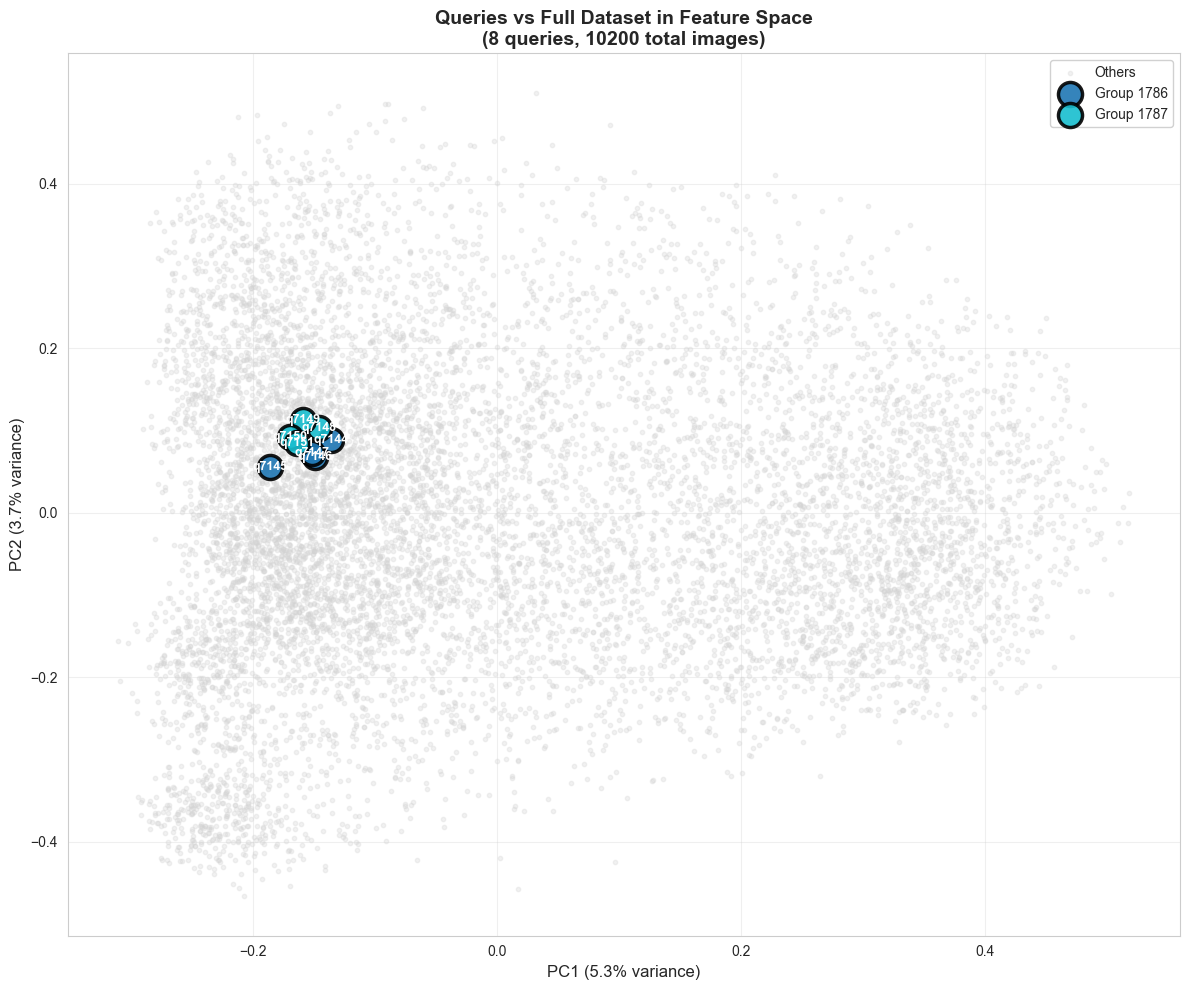


Visualization saved to: D:\sim-bench\outputs\feature_exploration\queries_vs_dataset_by_group.png


In [33]:
# Visualize queries vs dataset in 2D feature space
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.cm as cm

# Reduce all features to 2D
pca = PCA(n_components=2)
all_2d = pca.fit_transform(features)
query_2d = pca.transform(query_features)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Plot dataset (as "others" in gray)
ax.scatter(all_2d[:, 0], all_2d[:, 1], 
          c='lightgray', s=10, alpha=0.3, label='Others', rasterized=True)

# Get unique groups in queries and assign colors
unique_groups = sorted(set(query_group_ids))
colors = cm.tab10(np.linspace(0, 1, len(unique_groups)))
group_to_color = dict(zip(unique_groups, colors))

# Plot query images (colored by group)
for i, (idx, gid) in enumerate(zip(query_indices, query_group_ids)):
    ax.scatter(query_2d[i, 0], query_2d[i, 1], 
              c=[group_to_color[gid]], s=300, alpha=0.9, 
              edgecolors='black', linewidth=2.5, 
              label=f'Group {gid}' if i == query_group_ids.index(gid) else None,
              zorder=10)
    ax.annotate(f'q{idx}', 
               (query_2d[i, 0], query_2d[i, 1]),
               fontsize=9, ha='center', va='center', 
               fontweight='bold', color='white', zorder=11)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.set_title(f'Queries vs Full Dataset in Feature Space\n'
            f'({len(query_indices)} queries, {len(features)} total images)', 
            fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = OUTPUT_DIR / 'queries_vs_dataset_by_group.png'
plt.savefig(output_file, dpi=150, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to: {output_file}")

## 5. Feature Attribution (ResNet-50 Only)

Visualize which parts of images contribute to specific features using Grad-CAM.

**Note**: This section only works with the `deep` method (ResNet-50).

In [34]:
# Check if using deep method
if METHOD_NAME != 'deep':
    print(f"⚠️  Feature attribution only works with 'deep' method (ResNet-50)")
    print(f"   Current method: {METHOD_NAME}")
    print(f"   Skipping this section...")
else:
    print("✓ Using 'deep' method - feature attribution available")
    
    # Import attribution utilities
    from sim_bench.analysis.feature_attribution import ResNet50FeatureExtractor
    
    # Initialize extractor
    print("\nInitializing ResNet-50 feature extractor...")
    extractor = ResNet50FeatureExtractor(device='cpu')  # Use 'cuda' if GPU available
    print("✓ Extractor ready")

✓ Using 'deep' method - feature attribution available

Initializing ResNet-50 feature extractor...
✓ Extractor ready


### Analyze Feature Importance for Query Images

In [35]:
# Analyze which features are most active for each query
if METHOD_NAME == 'deep':
    from sim_bench.analysis.feature_attribution import analyze_feature_importance
    
    query_feature_importance = []
    
    for i, (query_idx, query_path) in enumerate(zip(query_indices, query_paths)):
        print(f"\nQuery {query_idx}: {Path(query_path).name}")
        
        # Analyze top features
        importance = analyze_feature_importance(extractor, query_path, top_k=10)
        query_feature_importance.append(importance)
        
        print(f"  Top 10 most active features:")
        for rank, (feat_idx, feat_val) in enumerate(zip(
            importance['top_indices'], 
            importance['top_values']
        ), 1):
            print(f"    {rank:2d}. Feature {feat_idx:4d}: {feat_val:.4f}")


Query 7144: ukbench07144.jpg
  Top 10 most active features:
     1. Feature 1116: 0.3200
     2. Feature  906: 0.3138
     3. Feature 1098: 0.2555
     4. Feature  632: 0.2498
     5. Feature  208: 0.2348
     6. Feature  367: 0.2233
     7. Feature  990: 0.2182
     8. Feature 1204: 0.1884
     9. Feature 1781: 0.1773
    10. Feature  258: 0.1719

Query 7145: ukbench07145.jpg
  Top 10 most active features:
     1. Feature  367: 0.4337
     2. Feature 1204: 0.2986
     3. Feature 1139: 0.2404
     4. Feature  443: 0.2261
     5. Feature 1116: 0.2203
     6. Feature  632: 0.1845
     7. Feature 1862: 0.1842
     8. Feature 1146: 0.1733
     9. Feature 1097: 0.1648
    10. Feature 1599: 0.1513

Query 7146: ukbench07146.jpg
  Top 10 most active features:
     1. Feature 1116: 0.3739
     2. Feature  208: 0.3281
     3. Feature  906: 0.2703
     4. Feature 1204: 0.2375
     5. Feature  367: 0.1873
     6. Feature  442: 0.1861
     7. Feature  990: 0.1796
     8. Feature 1207: 0.1758
     

### Visualize What Features Are Looking At (Grad-CAM)

In [36]:
# Visualize Grad-CAM for top features of first query
if METHOD_NAME == 'deep' and len(query_indices) > 0:
    from sim_bench.analysis.feature_attribution import visualize_feature_dimensions
    
    # Select first query
    query_idx = query_indices[0]
    query_path = query_paths[0]
    
    print(f"Creating Grad-CAM visualizations for query {query_idx}...")
    print(f"Image: {Path(query_path).name}")
    
    # Get top 5 features for this query
    importance = query_feature_importance[0]
    top_5_features = importance['top_indices'][:5].tolist()
    
    print(f"\nVisualizing top 5 features: {top_5_features}")
    
    # Create visualizations
    grad_cam_dir = OUTPUT_DIR / 'grad_cam' / f'query_{query_idx}'
    visualize_feature_dimensions(
        extractor,
        query_path,
        top_5_features,
        grad_cam_dir
    )
    
    print(f"\n✓ Grad-CAM visualizations saved to: {grad_cam_dir}")

Creating Grad-CAM visualizations for query 7144...
Image: ukbench07144.jpg

Visualizing top 5 features: [1116, 906, 1098, 632, 208]
Saved 5 visualizations to D:\sim-bench\outputs\feature_exploration\grad_cam\query_7144

✓ Grad-CAM visualizations saved to: D:\sim-bench\outputs\feature_exploration\grad_cam\query_7144


### Compare Feature Activations Across Queries

In [37]:
# Compare how different queries activate common features
if METHOD_NAME == 'deep' and len(query_indices) >= 2:
    from sim_bench.analysis.feature_attribution import compare_feature_activations
    
    # Select up to 4 queries for comparison
    compare_paths = query_paths[:min(4, len(query_paths))]
    compare_indices = query_indices[:min(4, len(query_indices))]
    
    print(f"Comparing feature activations across {len(compare_paths)} queries...")
    for idx, path in zip(compare_indices, compare_paths):
        print(f"  - Query {idx}: {Path(path).name}")
    
    # Create comparison visualization
    output_path = OUTPUT_DIR / 'feature_activation_comparison.png'
    compare_feature_activations(
        extractor,
        compare_paths,
        output_path,
        common_features=None  # Auto-detect common top features
    )
    
    print(f"\n✓ Comparison saved to: {output_path}")
elif METHOD_NAME == 'deep':
    print("Need at least 2 queries for comparison")

Comparing feature activations across 4 queries...
  - Query 7144: ukbench07144.jpg
  - Query 7145: ukbench07145.jpg
  - Query 7146: ukbench07146.jpg
  - Query 7147: ukbench07147.jpg
Comparison saved to D:\sim-bench\outputs\feature_exploration\feature_activation_comparison.png

✓ Comparison saved to: D:\sim-bench\outputs\feature_exploration\feature_activation_comparison.png


### Interpretation Guide

**What Grad-CAM Shows:**
- **Red/Yellow regions**: Areas that strongly activate the feature
- **Blue/Purple regions**: Areas with little contribution to the feature

**Understanding Features:**
- Each feature (0-2047) captures different visual patterns
- Some features focus on:
  - **Textures**: Patterns, materials, surface details
  - **Shapes**: Object boundaries, geometric forms
  - **Colors**: Color distributions and contrasts
  - **Objects**: Specific object types or parts

**Use Cases:**
- **Debug similarities**: Why are two images considered similar?
- **Understand failures**: What is the model focusing on?
- **Feature interpretation**: What does each feature dimension capture?

## Summary

This notebook provides tools for exploring feature representations:
- Load cached features from experiments
- Query specific images and analyze their features
- Compare images using feature distances
- Find nearest neighbors in feature space
- Visualize feature distributions and statistics